In [1]:
import relative_imports

In [2]:
import sys
sys.path.insert(1, "/HOME1/users/students/shvl/projects/spatiotemporal")

%matplotlib ipympl

from spatiotemporal.SEN12MSCRTS import DatasetManager, ImageUtils
from torch_datasets.minimal_dataset import S1Dataset
from tqdm.notebook import tqdm
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from os.path import join
from torch.utils.data import DataLoader
import xarray as xr

In [3]:
root_dir='/LOCAL2/shvl/datasets/cloud_removal/SEN12MSCRTS'
cloud_maps_dir="/LOCAL2/shvl/datasets/cloud_removal/SEN12MSCRTS_cloud_maps"
cloud_histograms_csv = join(cloud_maps_dir, "cloud_histograms.csv")

In [4]:
dataset_manager = DatasetManager(
    root_dir=root_dir,
    cloud_maps_dir=cloud_maps_dir
)

In [5]:
dataset_manager_path = join(dataset_manager.project_directory, "config", "dataset_manager.csv")

# dataset_manager.load_dataset()
# dataset_manager.save_to_file(dataset_manager_path)
dataset_manager.load_from_file(dataset_manager_path)

In [6]:
leftmost_edge = -50
rightmost_edge = 10
n_bins = 6000

bins = np.linspace(start=leftmost_edge, stop=rightmost_edge, num=n_bins+1)
bins, bins.shape

(array([-50.  , -49.99, -49.98, ...,   9.98,   9.99,  10.  ]), (6001,))

# Process single batch

In [7]:
dataset = S1Dataset(dataset_manager=dataset_manager, mode="train")

In [8]:
data_loader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=False,
    # num_workers=32,
    collate_fn=dataset.collate_fn,
    # prefetch_factor=2
)

In [9]:
iterator = iter(data_loader)
batch = next(iterator)

In [10]:
image = batch["S1_image"]

image.shape, image.min(), image.max()

((64, 2, 256, 256), -47.250596149684505, 6.701925574540008)

In [11]:
image = np.clip(image, a_min=-50, a_max=10)
image.shape, image.min(), image.max()

((64, 2, 256, 256), -47.250596149684505, 6.701925574540008)

In [12]:
batch_histogram = np.stack([
    np.histogram(image[:, 0], bins=bins)[0],
    np.histogram(image[:, 1], bins=bins)[0]
])

batch_histogram.shape, batch_histogram.dtype

((2, 6000), dtype('int64'))

In [13]:
with plt.ioff():
    fig_1, axs_1 = plt.subplots(figsize=(13, 5))

In [14]:
stairplot_1_VV = axs_1.stairs(
    values=batch_histogram[0],
    edges=bins,
    alpha=0.5,
    color="lightsteelblue",
    edgecolor="steelblue",
    fill=True,
    linewidth=0.5,
    label="VV"
)
stairplot_1_VH = axs_1.stairs(
    values=batch_histogram[1],
    edges=bins,
    alpha=0.5,
    color="orange",
    edgecolor="red",
    fill=True,
    linewidth=0.5,
    label="VH"
)
axs_1.set_ylabel("N pixels")
axs_1.set_xlabel("Backscatter [dB]")
axs_1.set_title(f"Sentinel-1 histogram (single batch)", fontsize=14)
axs_1.legend(title="Polarization")

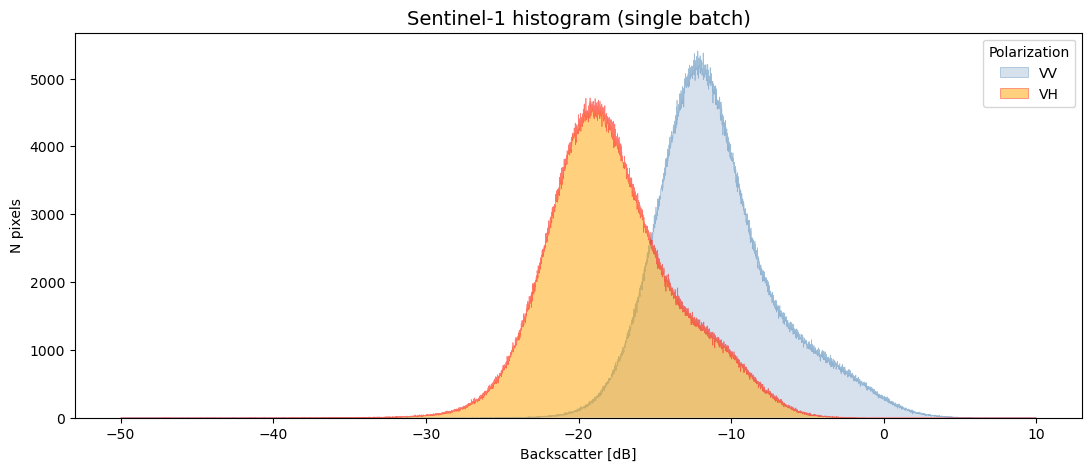

In [15]:
display(fig_1)

In [15]:
plt.close(fig_1)

# Create dataset for parallel histogram calculation

In [7]:
class S1HistogramDataset(S1Dataset):

    leftmost_edge = -50
    rightmost_edge = 10
    n_bins = 6000
    
    bins = np.linspace(start=leftmost_edge, stop=rightmost_edge, num=n_bins+1)
    
    bin_size = (rightmost_edge - leftmost_edge) / n_bins
    left_bin_edges = bins[:-1]
    right_bin_edges = bins[1:]
    mean_bin_value = left_bin_edges + bin_size/2
    
    def __init__(self, dataset_manager, mode):
        super().__init__(dataset_manager=dataset_manager, mode=mode)

    def __getitem__(self, idx):
        sample = super().__getitem__(idx)
        histogram = self.histogram(sample)
        sample["histogram"] = histogram
        return sample

    def histogram(self, sample):
        image = sample["S1_image"]
        nans = np.isnan(image)
        
        if nans.any():
            image[nans] = self.leftmost_edge
        
        image = np.clip(image, a_min=self.leftmost_edge, a_max=self.rightmost_edge)

        return np.stack([
            np.histogram(image[0], bins=self.bins)[0],
            np.histogram(image[1], bins=self.bins)[0]
        ])

    def collate_fn(self, list_of_samples):
        histogram = np.sum([sample["histogram"] for sample in list_of_samples], axis=0)
        result = super().collate_fn(list_of_samples)
        result["histogram"] = histogram
        return result

### Perform some tests

In [16]:
dataset = S1Dataset(dataset_manager=dataset_manager, mode="train")
histogram_dataset = S1HistogramDataset(dataset_manager=dataset_manager, mode="train")

In [17]:
data_loader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=False,
    # num_workers=32,
    collate_fn=dataset.collate_fn,
    # prefetch_factor=2
)
histogram_data_loader = DataLoader(
    histogram_dataset,
    batch_size=64,
    shuffle=False,
    # num_workers=32,
    collate_fn=histogram_dataset.collate_fn,
    # prefetch_factor=2
)

In [18]:
batch = next(iter(data_loader))
histogram_batch = next(iter(histogram_data_loader))

In [19]:
batch_image = batch["S1_image"]
batch_nans = np.isnan(batch_image)

if batch_nans.any():
    batch_image[batch_nans] = leftmost_edge

batch_image = np.clip(batch_image, a_min=leftmost_edge, a_max=rightmost_edge)

batch_histogram = np.stack([
    np.histogram(batch_image[:, 0], bins=bins)[0],
    np.histogram(batch_image[:, 1], bins=bins)[0]
])

batch_histogram.shape

In [20]:
# check if both produce the same result
assert (batch_histogram == histogram_batch["histogram"]).all()

# Process the whole dataset

In [21]:
histogram_dataset = S1HistogramDataset(dataset_manager=dataset_manager, mode="train")

In [22]:
assert 256 * 256 * len(histogram_dataset) < np.iinfo(np.int64).max

In [23]:
histogram_data_loader = DataLoader(
    histogram_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=64,
    collate_fn=histogram_dataset.collate_fn,
    prefetch_factor=2
)

In [8]:
dataset_histogram = np.zeros(
    (
        2,
        S1HistogramDataset.bins.size-1
    ),
    dtype=np.int64
)
dataset_histogram.shape, dataset_histogram.dtype

In [53]:
try:
    for batch in tqdm(histogram_data_loader, desc="Calculating dataset histogram", unit=" batch"):

        dataset_histogram += batch["histogram"]
        
except KeyboardInterrupt:
    pass

In [25]:
dataset_histogram_xr = xr.DataArray(
    data=dataset_histogram,
    dims=["Polarization", "Backscatter"],
    coords={
        "Polarization": ("Polarization", ["VV", "VH"]),
        "Backscatter": ("Backscatter", histogram_dataset.mean_bin_value),
        "left_bin_edge": ("Backscatter", histogram_dataset.left_bin_edges),
        "right_bin_edge": ("Backscatter", histogram_dataset.right_bin_edges)
    },
    name="Sentinel-1 histogram [dB]",
    attrs={"subset": "train"}
)
dataset_histogram_xr = dataset_histogram_xr.to_dataset()

dataset_histogram_xr

In [33]:
dataset_histogram_xr.to_netcdf(
    path=join(dataset_manager.project_directory, "stats", "S1_train_dataset_histogram.nc"), 
    encoding={'Sentinel-1 histogram [dB]':{'dtype': 'int32'}}
)

# Load histograms from drive and plot results

In [16]:
saved_histogram = xr.load_dataset(
    join(dataset_manager.project_directory, "stats", "S1_train_dataset_histogram.nc")
)
saved_histogram = saved_histogram["Sentinel-1 histogram [dB]"]
saved_histogram

<xarray.DataArray 'Sentinel-1 histogram [dB]' (Polarization: 2,
                                               Backscatter: 6000)>
array([[  12821,      97,      90, ...,   26124,   26192, 8555872],
       [ 320412,    2327,    2451, ...,    1170,    1159,  353972]],
      dtype=int32)
Coordinates:
  * Backscatter     (Backscatter) float64 -49.99 -49.98 -49.97 ... 9.985 9.995
    left_bin_edge   (Backscatter) float64 -50.0 -49.99 -49.98 ... 9.97 9.98 9.99
    right_bin_edge  (Backscatter) float64 -49.99 -49.98 -49.97 ... 9.99 10.0
  * Polarization    (Polarization) object 'VV' 'VH'
Attributes:
    subset:   train

In [17]:
with plt.ioff():
    fig_2, axs_2 = plt.subplots(figsize=(13, 5))

In [20]:
stairplot_2_VV = axs_2.stairs(
    values=saved_histogram.values[0],
    edges=bins,
    alpha=0.5,
    color="lightsteelblue",
    edgecolor="steelblue",
    fill=True,
    linewidth=0.5,
    label="VV"
)
stairplot_2_VH = axs_2.stairs(
    values=saved_histogram.values[1],
    edges=bins,
    alpha=0.5,
    color="orange",
    edgecolor="red",
    fill=True,
    linewidth=0.5,
    label="VH"
)
axs_2.set_ylabel("N pixels")
axs_2.set_xlabel("Backscatter [dB]")
axs_2.set_title(f"Sentinel-1 dataset histogram", fontsize=14)
axs_2.legend(title="Polarization")

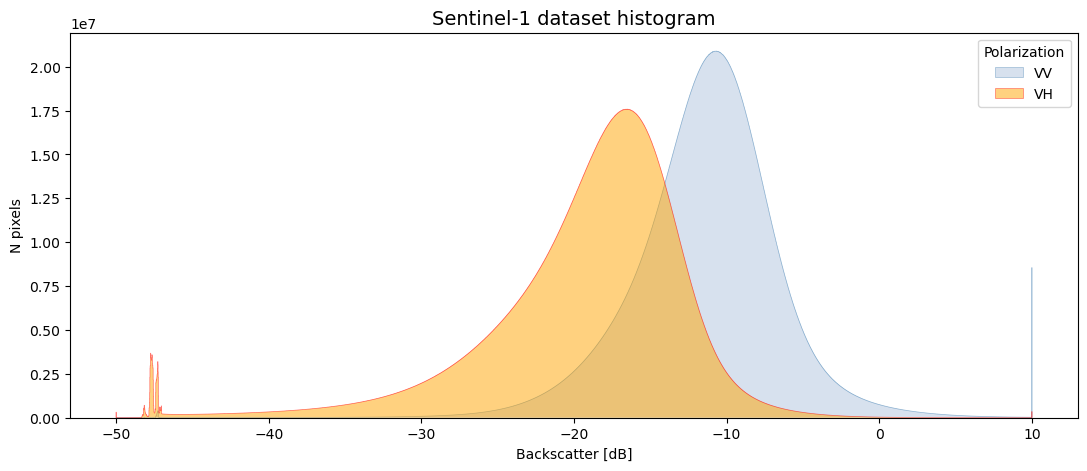

In [21]:
display(fig_2)

In [22]:
plt.close(fig_2)